In [65]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import healpy as hp
from scipy.interpolate import interp1d

nside = 1024
lmax = 1024*3-1

def iqu2teb(IQU, nside, lmax=None):
    print('a')
    alms = hp.map2alm(IQU, lmax=lmax, pol=True)
    print('b')
    return hp.alm2map(alms, nside=nside, lmax=lmax, pol=False)

def teb2iqu(TEB, nside, lmax=None):
    alms = hp.map2alm(TEB, lmax=lmax, pol=False)
    return hp.alm2map(alms, nside=nside, lmax=lmax, pol=True)

# Begin in Q, U 
### $a_{Q,U} = R \ a_{E,B} + n_{Q,U}$
### $d_{Q,U} = s_{Q,U} + n_{Q,U}$ 
### $\boldsymbol{d} = \boldsymbol{s} + \boldsymbol{n}$


# Algorithm
### $t = T/(T+N) \ d + \bar{N}/(\bar{N} + T) \  s $
### $ s = S/(S+T) \ t $


# Definitions
### $N_{Q,U} = \langle n_{Q,U} n_{Q,U}^\dagger  \rangle $
### $\bar{N} = N - T$
### $ T = \tau \times \mathbf{1}$ , where $\tau = {\rm{min}} \big( N \big)$

# Signal covariance

In [27]:
ell_ee, cell_ee = np.load('namaster_buzzard.npy')
cell_func = interp1d(np.hstack([ell_ee, [ell_ee[-1]+1,1e4]]),
                     np.hstack([cell_ee, [cell_ee[-10]*0.5,1e-15]]),
                     fill_value='extrapolate', kind='linear')

In [28]:
ell_cov, mmm_cov = hp.Alm.getlm(nside*3-1)
s_cov_diag =  np.hstack([cell_func(ell_cov),
                         ell_cov*0. + np.min(cell_func(ell_cov))*1e-6])

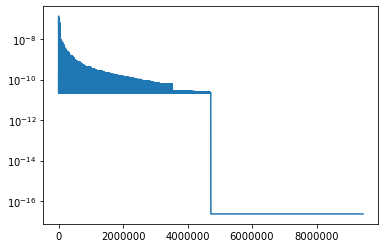

In [29]:
_ = plt.plot(s_cov_diag), plt.yscale('log')

# Data

In [30]:
data_IQU = hp.read_map('./map_mock_des1024.fits', field=(0,1,2))
data_vec = data_IQU[1] + 1j* data_IQU[2]

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


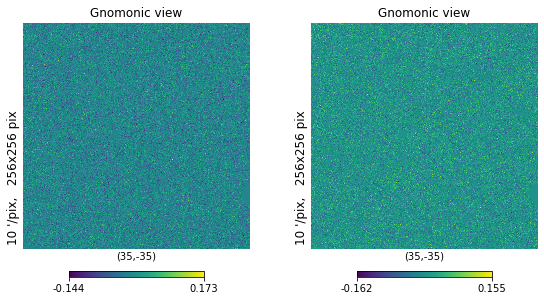

In [31]:
_ = plt.figure(figsize = (12,4)), hp.gnomview(data_vec.real, sub=(1,3,2), reso=10, rot = (35,-35), xsize=256)
_ = hp.gnomview(data_vec.imag, sub=(1,3,3), reso=10, rot = (35,-35), xsize=256)

# Noise covariance

In [33]:
noise_diag = np.load('noise_covariance_des1024.npz')['Cov_N']
noise_diag = np.concatenate([noise_diag[:,1,1],noise_diag[:,1,1]])

In [34]:
tau = np.min(noise_diag)
print(tau)
T_pixel = np.ones(noise_diag.shape)*tau
noise_bar_diag = noise_diag - tau

0.00017164225702445766


In [35]:
random_T_field = np.random.normal(0., np.sqrt(tau), hp.nside2npix(nside))

In [47]:
power_t_qq = hp.anafast(hp.ud_grade(random_T_field,nside), lmax = nside*3-1)
power_t_pol = hp.anafast([random_T_field*0.,random_T_field,random_T_field],
                          lmax = nside*3-1, pol = True)
tau_ell = np.mean([power_t_pol[1][50:nside*2], power_t_pol[2][50:nside*2], power_t_qq[50:nside*2]]) 

In [48]:
tau_ell

1.7146788238647262e-10

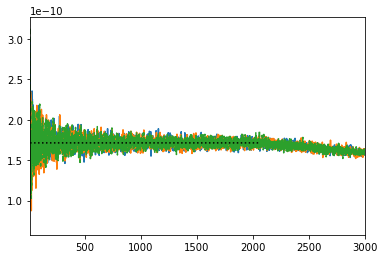

In [49]:
plt.plot(power_t_pol[1])
plt.plot(power_t_pol[2])
plt.plot([tau_ell]*nside*2, ':', c='black')
plt.plot(power_t_qq, '--'), plt.xlim(10,3000)
_ = plt.ylim(np.min(power_t_pol[2][50:nside*2])*0.5,np.max(power_t_pol[2][50:nside*2])*1.5)
plt.plot([tau_ell]*nside*2, ':', c='black')

In [50]:
T_ell = np.ones(s_cov_diag.shape)*tau_ell

# Implementation

In [51]:
s_cov_diag.shape

(9440256,)

In [52]:
T_ell.shape

(9440256,)

In [53]:
data_vec.shape

(12582912,)

In [54]:
n_iter = 10
data_vec_QU = np.concatenate([data_vec.real, data_vec.imag])
s = np.zeros(data_vec_QU.shape, dtype='complex')

convergence_test = [0.]


harmonic_operator = s_cov_diag/(s_cov_diag+T_ell)
pixel_operator_signal = (noise_bar_diag/(noise_bar_diag+T_pixel))
pixel_operator_data = (T_pixel / (T_pixel + noise_diag))

for i in range(n_iter):
    
    t = pixel_operator_data * data_vec_QU + pixel_operator_signal*s # here t = concat[t_Q, t_U]
#     print(np.max(t.imag))
    t = np.real(t)
    t = [t[int(t.shape[0]/2):]*0.,t[:int(t.shape[0]/2)],t[int(t.shape[0]/2):]] # here t = {t_I = 0, t_Q, t_U}
    t = hp.ud_grade(t, nside) # now upgrade
    
    t_alm = hp.map2alm(t, lmax = 3*(nside)-1, pol=True) 
    
#     print(np.max(t_alm[0]))
#     print(np.max(t_alm[1]))
#     print(np.max(t_alm[2]))
    
    s = harmonic_operator*np.concatenate([t_alm[1], t_alm[2]])
    s = [s[int(s.shape[0]/2):]*0.,s[:int(s.shape[0]/2)],s[int(s.shape[0]/2):]]
    
    print(np.var(s[0]), np.var(s[1]), np.var(s[2]))
    convergence_test.append(np.var(s[1]))
    

    s = hp.alm2map(s, nside=nside, lmax=nside*3-1, verbose=False, pol=True)
    s_qu = np.copy(s)
    s = np.concatenate([s[1], s[2]])

0.0 1.9193113142990887e-13 4.704195194193832e-26
0.0 3.8040908859574125e-13 4.695678556226358e-26
0.0 5.15582718582529e-13 4.693071637513053e-26
0.0 6.139565285817972e-13 4.691877468912446e-26
0.0 6.869528784389081e-13 4.6911994015603934e-26
0.0 7.419399131818058e-13 4.6907670154093733e-26
0.0 7.838632713779e-13 4.6904709572276806e-26
0.0 8.161626669722862e-13 4.690258230479667e-26
0.0 8.412901116516505e-13 4.6900999607434107e-26
0.0 8.610228986050987e-13 4.6899790588313463e-26


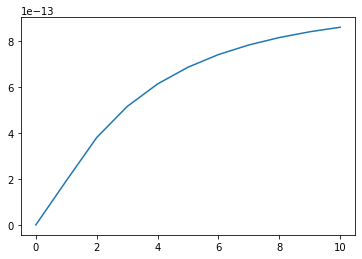

In [58]:
plt.plot(convergence_test)

In [66]:
# s_eb = iqu2teb(hp.ud_grade(s_qu,nside*2), nside*2, lmax = nside*2*3 -1)
# s_eb = hp.ud_grade(s_eb,nside)

s_eb = iqu2teb(s_qu, nside, lmax = nside*3 -1)

a
b
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


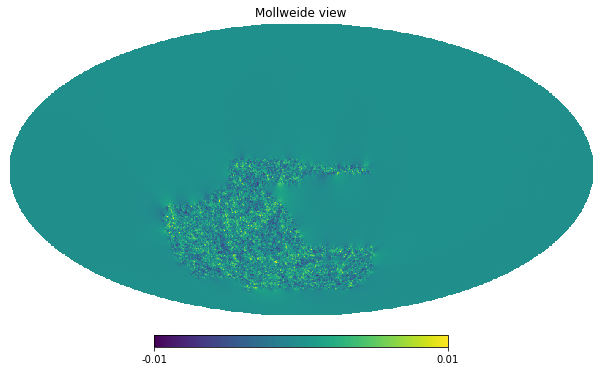

In [74]:
hp.mollview(s_eb[1], min = -0.01, max = 0.01)

In [71]:
np.save('test_wiener2_E_200120', np.array(s_eb[1], dtype = 'float'))

In [ ]:
# s_eb_128 = np.copy(s_eb)

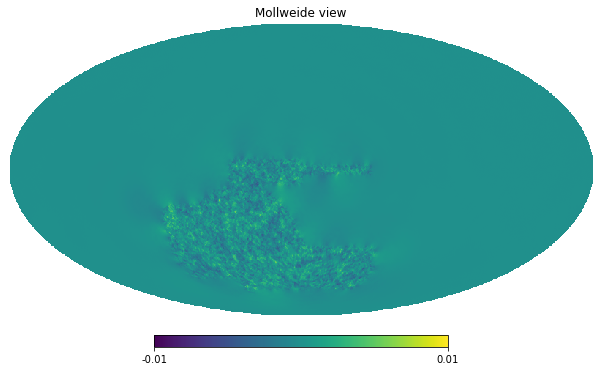

In [60]:
hp.mollview(s_eb_128[1], min = -0.01, max = 0.01)

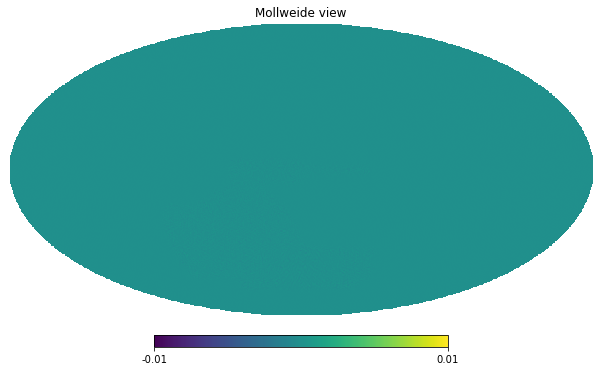

In [61]:
hp.mollview(s_eb_128[2], min = -0.01, max = 0.01)